# Node Centrality (Demo)

In this demo we  
- learn how to convert network from multiplex directional into singleplex or undirected,
- learn how to calculate and plot the different classes of centrality.

More information about centralities you can find here: https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html 

More information about PageRank is here: https://networkx.github.io/documentation/stable/reference/algorithms/link_analysis.html


In [1]:
import sys
sys.path.append('../libs/')
import compsoc as cs

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Elite families: Multiplex ties in Renaissance Florence
This is the dataset used in the introductory lecture. But we are not using the collection that networkx provides, but a multiplex one that is read directly from the [original paper](https://doi.org/10.1086/230190) by Padgett & Ansell (1993):

In [2]:
#read the data
#families = pd.read_csv('../data/elite_families/families.txt', sep='\t', encoding='utf-8')
#relations = pd.read_csv('../data/elite_families/relations.txt', sep='\t', encoding='utf-8')

families, _, relations, _ = cs.elite_families_collection(path='../../data/elite_families/')
families.head()

,family_id,family,party_id,gross_wealth_mean,date_of_first_prior_mean,block_size,numbers_active_medici,numbers_active_oligarch,numbers_active_neutral,pos_x,pos_y,partisanship_color,status_color
0,0,MEDICI,0,82702,1318,3,7,0,0,-0.0776,0.0391,#387db8,#b6b6b6
1,1,TORNABUONI,0,42840,1303,7,8,1,1,0.0776,0.1251,#5c82b0,#d4d4d4
2,2,GUICCIARDINI,0,40617,1289,5,6,0,0,-0.1761,-0.0705,#387db8,#f1f1f1
3,3,GINORI,0,21167,1344,2,11,0,0,-0.2381,0.1034,#387db8,#818181
4,4,DIETISALVI,0,13137,1340,2,3,0,0,-0.4000,0.1282,#387db8,#898989


In [3]:
#show information about size and data types of each column 
families.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   family_id                 33 non-null     int64  
 1   family                    33 non-null     object 
 2   party_id                  33 non-null     int64  
 3   gross_wealth_mean         33 non-null     int64  
 4   date_of_first_prior_mean  33 non-null     int64  
 5   block_size                33 non-null     int64  
 6   numbers_active_medici     33 non-null     int64  
 7   numbers_active_oligarch   33 non-null     int64  
 8   numbers_active_neutral    33 non-null     int64  
 9   pos_x                     33 non-null     float64
 10  pos_y                     33 non-null     float64
 11  partisanship_color        33 non-null     object 
 12  status_color              33 non-null     object 
dtypes: float64(2), int64(8), object(3)
memory usage: 3.5+ KB


Meaning of some columns:
- "date_of_first_prior_mean" is "the date of first Prior measures how old and dignified one's family was", here mean is used since each family is the block of families
- "block_size": is the number of families in the family block
- "status_color": is the mean age transformed into shades of grey/black. The lighter the color - the older they are
- "pos_x", "pos_y" are based on Force-Directed Layouting 
- "domain_id" is the code of the type of relations (kinship, economic, political, friendship)

In [4]:
relations.head()

,family_id_from,family_id_to,weight,domain_id
0,0,1,1,0
1,0,23,1,0
2,2,0,1,0
3,3,4,1,0
4,5,3,1,0


In [5]:
#show information about size and data types of each column
relations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   family_id_from  86 non-null     int64
 1   family_id_to    86 non-null     int64
 2   weight          86 non-null     int64
 3   domain_id       86 non-null     int64
dtypes: int64(4)
memory usage: 2.8 KB


Construct the weighted `MultiDiGraph()`:

In [6]:
G = cs.construct_graph(
    directed=True, 
    multiplex=True, 
    graph_name='elite_families', 
    node_list=families, 
    edge_list=relations, 
    node_pos=['pos_x', 'pos_y'], 
    node_size='gross_wealth_mean', 
    node_color='partisanship_color', 
    node_shape='party_id', 
    node_border_color='status_color', 
    node_label='family', 
    layer_color={0: '#984ea3', 1: '#ff7f00', 2: '#4daf4a', 3: '#a65628'}
)

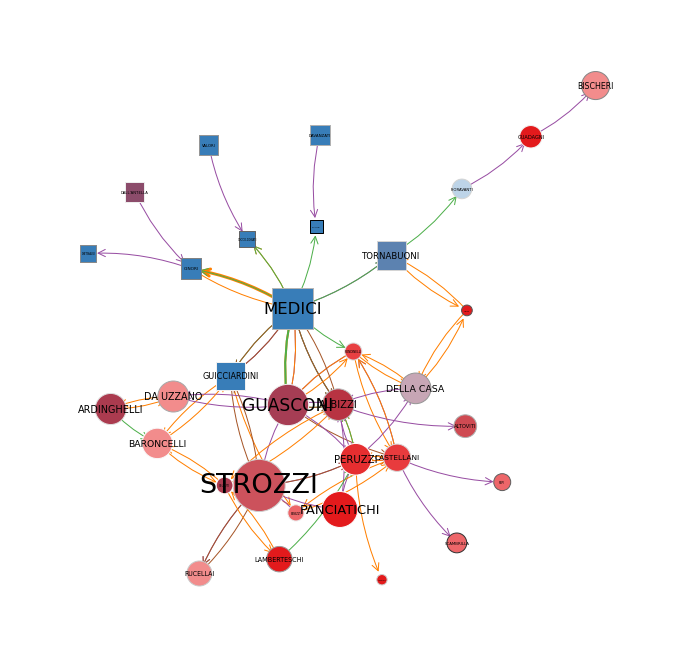

In [7]:
#draw the graph
cs.draw_graph(
    G, 
    node_size_factor=0.02, 
    curved_edges=True, 
    labels='text', 
    font_size_factor=.0002
)

## Convert directed network to undirected and backwards

Convert the network into

1. to singleplex directed,
2. to undirected.

For many analyses, it is necessary to study undirected networks or networks without parallel edges. A `MultiDiGraph()` can be transformed to a `DiGraph()`, i.e., parallel edges in multiple layers are removed using the former as data for the latter.

In [8]:
#convert to directed network
H = nx.DiGraph(G)

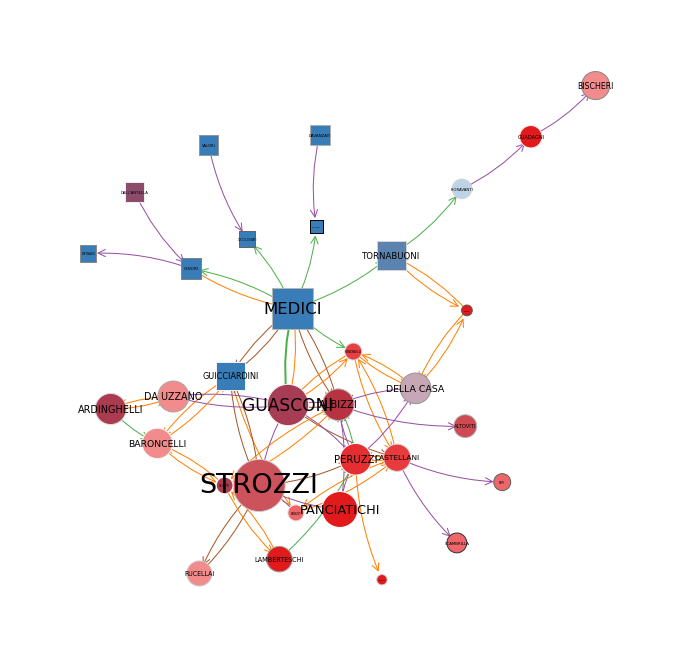

In [9]:
cs.draw_graph(
    H, 
    node_size_factor=0.02, 
    curved_edges=True, 
    labels='text', 
    font_size_factor=.0002
)

Compare the two graphs. What is the problem with this network? Which data do we miss?


The way networkx removes parallel edges is arbitrary – networkx keeps all attributes of the last parallel edge. Regarding edge weights, we would like to obtain the sum of parallel edge weights. To stay in control of our data, we can do this in the dataframe:

In [10]:
#show potential output of the grouping
relations.groupby(['family_id_from', 'family_id_to']).sum()[["weight"]]

weight
family_id_from family_id_to        
0              1                  2
               2                  2
               3                  4
               6                  1
               8                  2
...                             ...
28             29                 1
29             2                  1
               28                 1
30             31                 1
32             30                 1

[70 rows x 1 columns]

In [11]:
relations_singleplex = relations.groupby(['family_id_from',
                                          'family_id_to']).sum().reset_index()[['family_id_from', 
                                                                                'family_id_to', 'weight']]

With the `relations_singleplex` DataFrame, we can now construct a weighted `DiGraph()`:

In [12]:
G_singleplex = cs.construct_graph(
    directed=True, 
    multiplex=False, 
    graph_name='elite_families_singleplex', 
    node_list=families, 
    edge_list=relations_singleplex, 
    node_pos=['pos_x', 'pos_y'], 
    node_size='gross_wealth_mean', 
    node_color='partisanship_color', 
    node_shape='party_id', 
    node_border_color='status_color', 
    node_label='family'
)

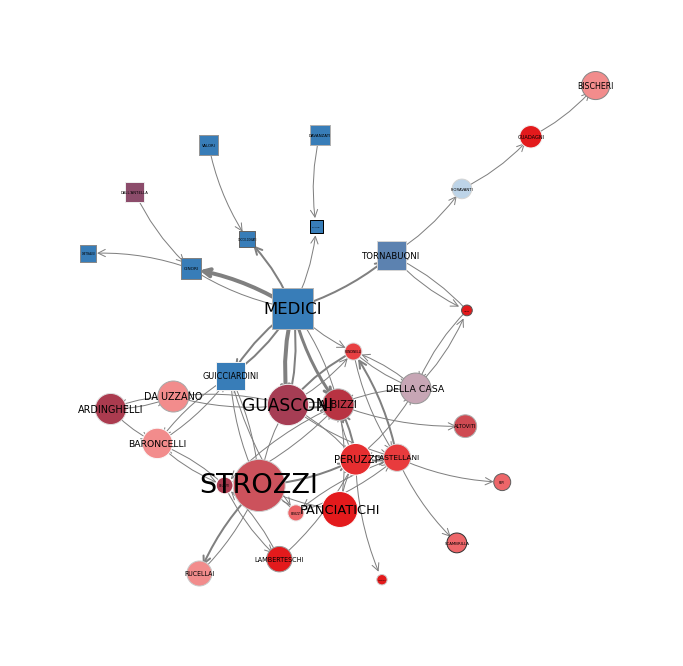

In [13]:
cs.draw_graph(
    G_singleplex, 
    node_size_factor=0.02, 
    curved_edges=True, 
    labels='text', 
    font_size_factor=.0002
)

Some algorithms do not work or do not make sense with directed graphs, or one may want to have an undirected `Graph()` for comparison. 

For this purpose, networkx provides a method, `to_undirected()`. But, again, the result is arbitrary.

Compsoc provides the `weighted_edge_list_to_undirected()` function to perform systematic transformations on the weighted edge list before the graph is constructed. 

`weighted_edge_list_to_undirected(edge_list, reciprocal=False, function='sum')`

- Where the `edge_list` is a Dataframe of a directed weighted edge list; the first column must be the identifier of node u, the second column must be identifier of node v, the third column must be edge weight w; all but the first three columns will be discarded.
- the `reciprocal` is a boolean variable if only reciprocated ties should be kept; set to False by default.
- the `function` is a function to chose edge weight after transformation; it specifies whether the smaller (`min`), larger (`max`), or summed (`sum`) weight of reciprocated ties ((u, v) and (v, u)) should be chosen; set to 'sum' by default.

In [14]:
#let's check weights of edges that start at node 0, 2, or 3. 
relations_singleplex[relations_singleplex.family_id_from.isin([0,2,3]) ]

,family_id_from,family_id_to,weight
0,0,1,2
1,0,2,2
2,0,3,4
3,0,6,1
4,0,8,2
5,0,12,4
6,0,13,1
7,0,23,3
10,2,0,2
11,2,19,1


In [15]:
#we will use default settings (reciprocal=False, function='sum') when removing parralel edges
relations_singleplex_undirected=cs.weighted_edge_list_to_undirected(relations_singleplex)

In [16]:
relations_singleplex_undirected

,family_id_from,family_id_to,weight
0,0,1,2
1,0,2,4
2,0,3,5
3,0,6,1
4,0,8,2
5,0,12,6
6,0,13,1
7,0,23,4
8,1,26,2
9,1,32,1


In [17]:
G_singleplex_undirected = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='elite_families_singleplex_undirected', 
    node_list=families, 
    edge_list=relations_singleplex_undirected, 
    node_pos=['pos_x', 'pos_y'], 
    node_size='gross_wealth_mean', 
    node_color='partisanship_color', 
    node_shape='party_id', 
    node_border_color='status_color', 
    node_label='family'
)

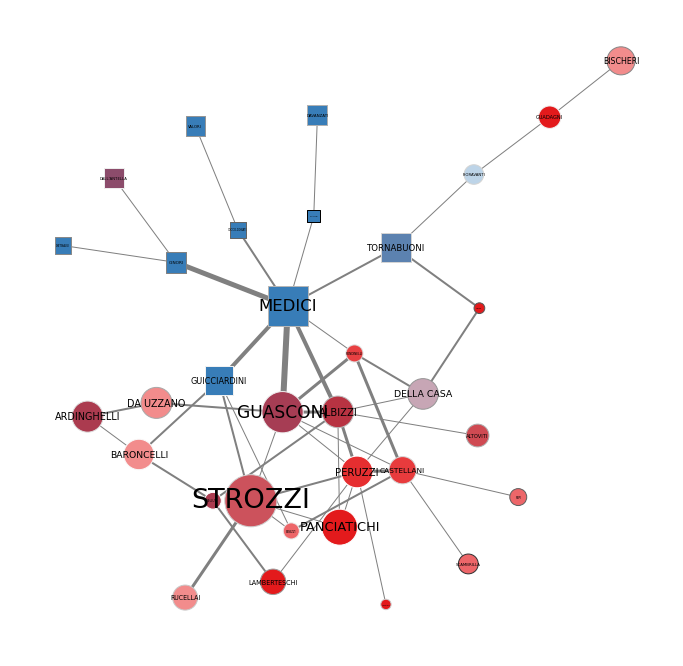

In [18]:
cs.draw_graph(
    G_singleplex_undirected, 
    node_size_factor=0.02, 
    curved_edges=True, 
    labels='text', 
    font_size_factor=.0002
)

Just for fun, one can remove the edge weights from `G_singleplex_undirected` to obtain a simple graph. In practice one would simply not use the 'weight' attribute when computing, e.g., a centrality score.

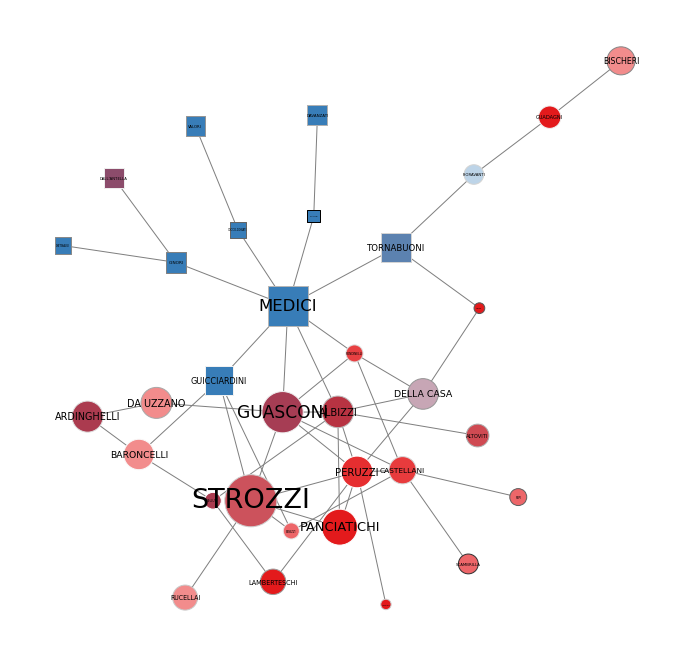

In [19]:
#create undirected graph from G_singleplex_undirected
G_simple=nx.Graph(G_singleplex_undirected)

#create dict with the attribute equal 1 and name the attribute "weight"
attr_dict={(s, t): 1  for s,t,obj in G_simple.edges(data=True)}
nx.set_edge_attributes(G_simple, values=attr_dict, name='weight')

cs.draw_graph(
    G_simple, 
    node_size_factor=0.02, 
    curved_edges=True, 
    labels='text', 
    font_size_factor=.0002)

## Check if graph is directed or multilayered

In [20]:
G.is_directed()

True

In [21]:
#Check which graph is directed
for i in [G,G_singleplex,G_singleplex_undirected,G_simple]:
    print (i.name,"\t\t",i.is_directed())

#Check which graph is multilayered    
print ("Multigraphs:")
for i in [G,G_singleplex,G_singleplex_undirected,G_simple]:
    print (i.name,"\t\t",i.is_multigraph())

elite_families 		 True
elite_families_singleplex 		 True
elite_families_singleplex_undirected 		 False
elite_families_singleplex_undirected 		 False
Multigraphs:
elite_families 		 True
elite_families_singleplex 		 False
elite_families_singleplex_undirected 		 False
elite_families_singleplex_undirected 		 False


# Calculate centralities

## Degree centrality

The __degree__ is the number of ties a node has.

The __degree centrality__ for a node _v_ is the fraction of nodes it is connected to. It measures potential communication activity. 

In [22]:
#shows how many connections each node has
#Note: degree_centrality function do not take into account weights of edges
nx.degree_centrality(G)#The top families: 0, 12 and 23

{0: 0.65625,
 1: 0.15625,
 2: 0.28125,
 3: 0.15625,
 4: 0.03125,
 5: 0.03125,
 6: 0.0625,
 7: 0.03125,
 8: 0.09375,
 9: 0.03125,
 10: 0.09375,
 11: 0.125,
 12: 0.46875,
 13: 0.28125,
 14: 0.03125,
 15: 0.40625,
 16: 0.34375,
 17: 0.03125,
 18: 0.03125,
 19: 0.125,
 20: 0.3125,
 21: 0.09375,
 22: 0.09375,
 23: 0.46875,
 24: 0.03125,
 25: 0.1875,
 26: 0.125,
 27: 0.09375,
 28: 0.1875,
 29: 0.15625,
 30: 0.0625,
 31: 0.03125,
 32: 0.0625}

Compsoc's function `draw_graph` take dictionary as `node_size`.

Networkx's  `draw()` takes list as `node_size`. Moreover, with `draw()` at one time you can only plot one shape of node.

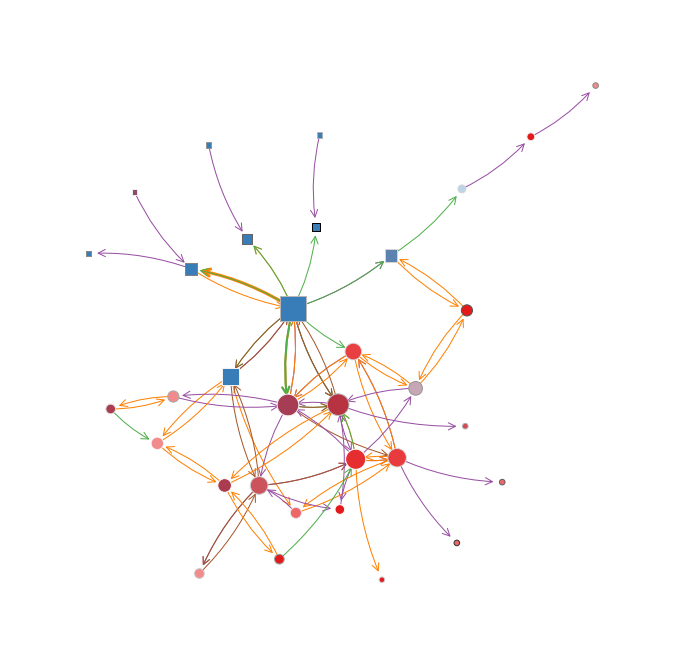

In [23]:
cs.draw_graph(
    G, 
    node_size=nx.degree_centrality(G), 
    node_size_factor=1000, 
    curved_edges=True)

In [24]:
#shows to how many other nodes each node is connected
nx.degree_centrality(G_singleplex_undirected)##The top families: 0 and 15, 12 and 23
#would produce the same result as:
#nx.degree_centrality(G_simple)

{0: 0.25,
 1: 0.09375,
 2: 0.125,
 3: 0.09375,
 4: 0.03125,
 5: 0.03125,
 6: 0.0625,
 7: 0.03125,
 8: 0.0625,
 9: 0.03125,
 10: 0.0625,
 11: 0.0625,
 12: 0.21875,
 13: 0.125,
 14: 0.03125,
 15: 0.25,
 16: 0.1875,
 17: 0.03125,
 18: 0.03125,
 19: 0.09375,
 20: 0.1875,
 21: 0.03125,
 22: 0.09375,
 23: 0.21875,
 24: 0.03125,
 25: 0.125,
 26: 0.0625,
 27: 0.0625,
 28: 0.09375,
 29: 0.09375,
 30: 0.0625,
 31: 0.03125,
 32: 0.0625}

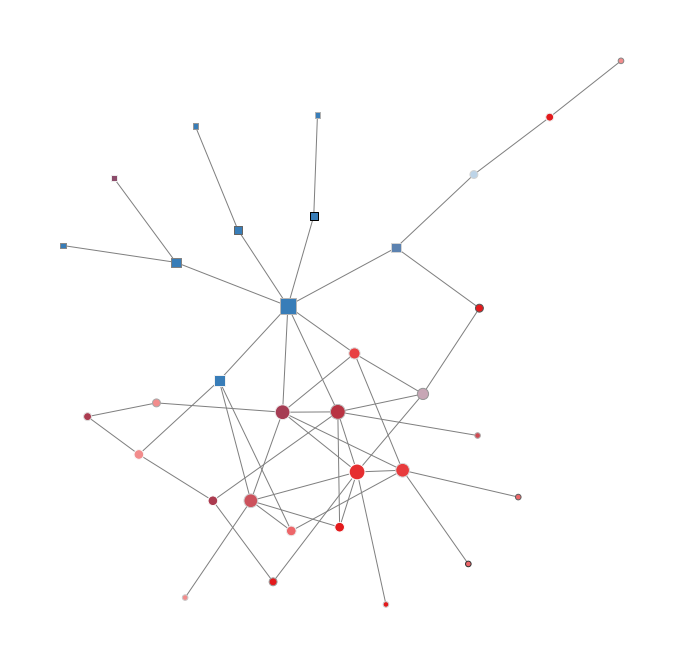

In [25]:
cs.draw_graph(
    G_simple, 
    node_size=nx.degree_centrality(G_singleplex_undirected), 
    node_size_factor=1000)

In [26]:
G_singleplex_undirected.edges(data=True)

EdgeDataView([(0, 1, {'weight': 2}), (0, 2, {'weight': 4}), (0, 3, {'weight': 5}), (0, 6, {'weight': 1}), (0, 8, {'weight': 2}), (0, 12, {'weight': 6}), (0, 13, {'weight': 1}), (0, 23, {'weight': 4}), (1, 26, {'weight': 2}), (1, 32, {'weight': 1}), (2, 19, {'weight': 1}), (2, 20, {'weight': 2}), (2, 29, {'weight': 2}), (3, 4, {'weight': 1}), (3, 5, {'weight': 1}), (6, 7, {'weight': 1}), (8, 9, {'weight': 1}), (10, 11, {'weight': 2}), (10, 29, {'weight': 1}), (11, 12, {'weight': 2}), (12, 13, {'weight': 3}), (12, 15, {'weight': 1}), (12, 16, {'weight': 1}), (12, 20, {'weight': 1}), (12, 23, {'weight': 3}), (13, 16, {'weight': 3}), (13, 25, {'weight': 2}), (14, 15, {'weight': 1}), (15, 16, {'weight': 3}), (15, 20, {'weight': 2}), (15, 22, {'weight': 1}), (15, 23, {'weight': 3}), (15, 25, {'weight': 1}), (15, 27, {'weight': 1}), (16, 17, {'weight': 1}), (16, 18, {'weight': 1}), (16, 19, {'weight': 2}), (19, 20, {'weight': 1}), (20, 21, {'weight': 3}), (20, 22, {'weight': 1}), (22, 23, {'w

In [27]:
#shows node strength in weighted network
#Note: this is not normalized value; can be normalized by sum of edge weights
#G_singleplex_undirected.degree(weight='weight')
#OR
G.degree(weight='weight')

DiMultiDegreeView({0: 25, 1: 5, 2: 9, 3: 7, 4: 1, 5: 1, 6: 2, 7: 1, 8: 3, 9: 1, 10: 3, 11: 4, 12: 17, 13: 9, 14: 1, 15: 13, 16: 11, 17: 1, 18: 1, 19: 4, 20: 10, 21: 3, 22: 3, 23: 15, 24: 1, 25: 6, 26: 4, 27: 3, 28: 6, 29: 5, 30: 2, 31: 1, 32: 2})

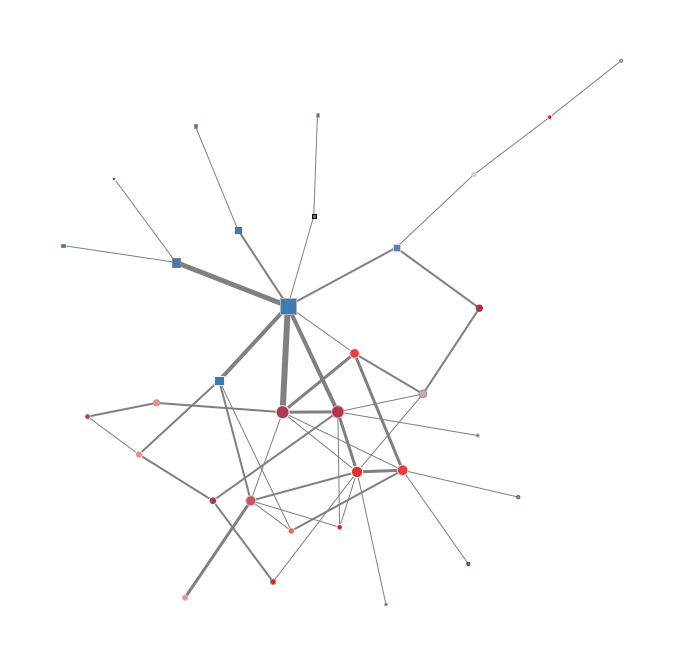

In [28]:
cs.draw_graph(
    G_singleplex_undirected, 
    node_size=dict(G_singleplex_undirected.degree(weight='weight')), 
    node_size_factor=10)

In [29]:
#You can check the following degrees:
#G.degree(0)
#G.degree(0,weight="weight")
#G_singleplex_undirected.degree(0)
#G_singleplex_undirected.degree(0,weight="weight")

### In-degree centrality
The __in-degree centrality__ for a node _v_ is the fraction of nodes its incoming edges are connected to.

In [30]:
#shows how many incoming connections each node has
nx.in_degree_centrality(G)#The top families: 23, 12, 0 

{0: 0.1875,
 1: 0.09375,
 2: 0.125,
 3: 0.09375,
 4: 0.03125,
 5: 0.0,
 6: 0.0625,
 7: 0.0,
 8: 0.09375,
 9: 0.0,
 10: 0.03125,
 11: 0.0625,
 12: 0.21875,
 13: 0.15625,
 14: 0.03125,
 15: 0.15625,
 16: 0.15625,
 17: 0.03125,
 18: 0.03125,
 19: 0.0625,
 20: 0.125,
 21: 0.0625,
 22: 0.0625,
 23: 0.3125,
 24: 0.03125,
 25: 0.09375,
 26: 0.0625,
 27: 0.03125,
 28: 0.09375,
 29: 0.09375,
 30: 0.03125,
 31: 0.03125,
 32: 0.03125}

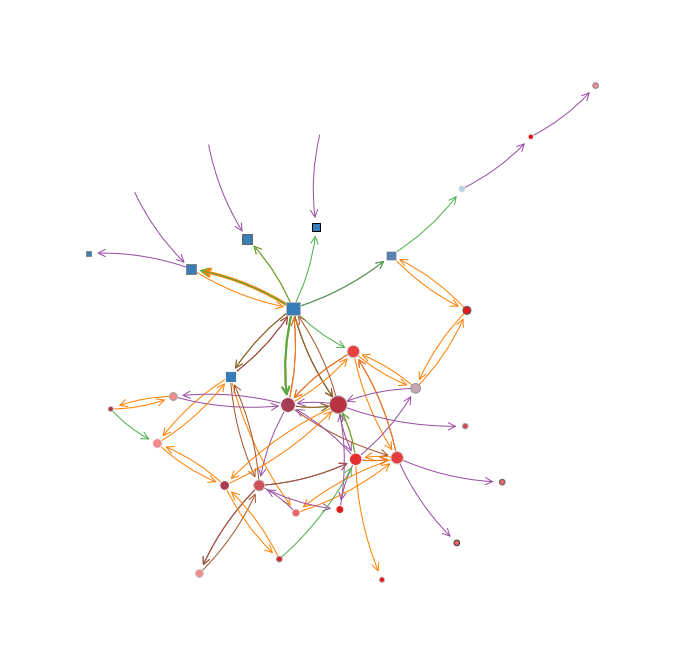

In [31]:
cs.draw_graph(
    G, 
    node_size=nx.in_degree_centrality(G), 
    node_size_factor=1000, 
    curved_edges=True)

In [32]:
#shows the strength of incoming connections
G_singleplex.in_degree(weight='weight')#Top: 23, 12, 0
#OR
#G.in_degree(weight='weight')


InDegreeView({0: 6, 1: 3, 2: 4, 3: 5, 4: 1, 5: 0, 6: 2, 7: 0, 8: 3, 9: 0, 10: 1, 11: 2, 12: 9, 13: 5, 14: 1, 15: 5, 16: 5, 17: 1, 18: 1, 19: 2, 20: 4, 21: 2, 22: 2, 23: 10, 24: 1, 25: 3, 26: 2, 27: 1, 28: 3, 29: 3, 30: 1, 31: 1, 32: 1})

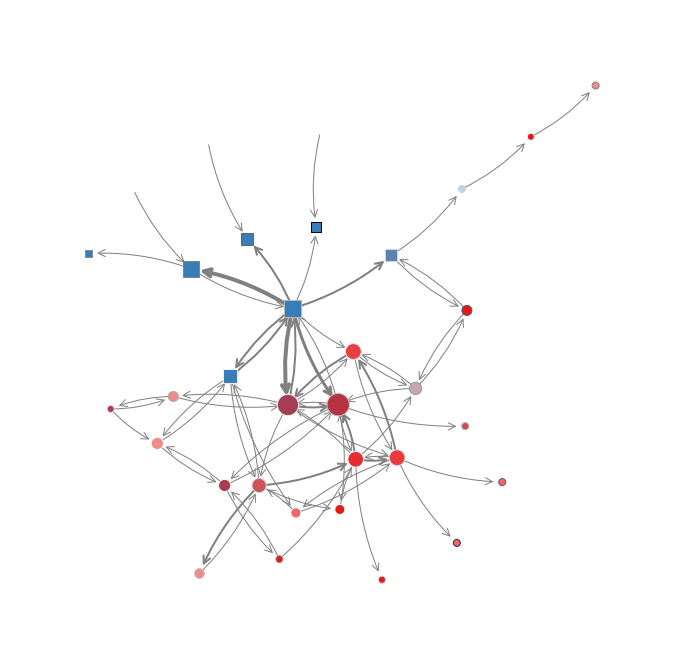

In [33]:
cs.draw_graph(
    G_singleplex, 
    node_size=dict(G.in_degree(weight='weight')), 
    node_size_factor=50, 
    curved_edges=True)

### Out-degree centrality
The __out-degree centrality__ for a node _v_ is the fraction of nodes its outgoing edges are connected to.

In [34]:
#shows how many outcoming connections each node has
nx.out_degree_centrality(G)#0, 12 and 25

{0: 0.46875,
 1: 0.0625,
 2: 0.15625,
 3: 0.0625,
 4: 0.0,
 5: 0.03125,
 6: 0.0,
 7: 0.03125,
 8: 0.0,
 9: 0.03125,
 10: 0.0625,
 11: 0.0625,
 12: 0.25,
 13: 0.125,
 14: 0.0,
 15: 0.25,
 16: 0.1875,
 17: 0.0,
 18: 0.0,
 19: 0.0625,
 20: 0.1875,
 21: 0.03125,
 22: 0.03125,
 23: 0.15625,
 24: 0.0,
 25: 0.09375,
 26: 0.0625,
 27: 0.0625,
 28: 0.09375,
 29: 0.0625,
 30: 0.03125,
 31: 0.0,
 32: 0.03125}

In [35]:
#shows the strength of outcoming connections
G_singleplex.out_degree(weight='weight')#Top: 0, 12 and 15, 16 and 20
#OR
#G.out_degree(weight='weight')

OutDegreeView({0: 19, 1: 2, 2: 5, 3: 2, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 2, 11: 2, 12: 8, 13: 4, 14: 0, 15: 8, 16: 6, 17: 0, 18: 0, 19: 2, 20: 6, 21: 1, 22: 1, 23: 5, 24: 0, 25: 3, 26: 2, 27: 2, 28: 3, 29: 2, 30: 1, 31: 0, 32: 1})

## Closeness Centrality 

This is based on the assumption that important nodes are close to other nodes. These metrics measure potential independence or efficiency.

__Closeness centrality__ of a node _u_ is the reciprocal of the average shortest path distance to _u_ over all _n-1_ reachable nodes. 
> Notice that the closeness distance function computes the incoming distance to _u_ for directed graphs. To use outward distance, act on _G.reverse()_.

`closeness_centrality(G, u=None, distance=None)` where `u` is node for which centrality should be calculated and `distance` edge attribute name that should be used to calculate distance in shortest pathes.

Clothenes centrality do not differentiate between multiplex and singleplex network, i.e, multiple edges are not taken into account.  

In [36]:
#closeness to this node from other nodes
print (nx.closeness_centrality(G)[3])
print (nx.closeness_centrality(G_singleplex)[3])

0.20491803278688522
0.20491803278688522


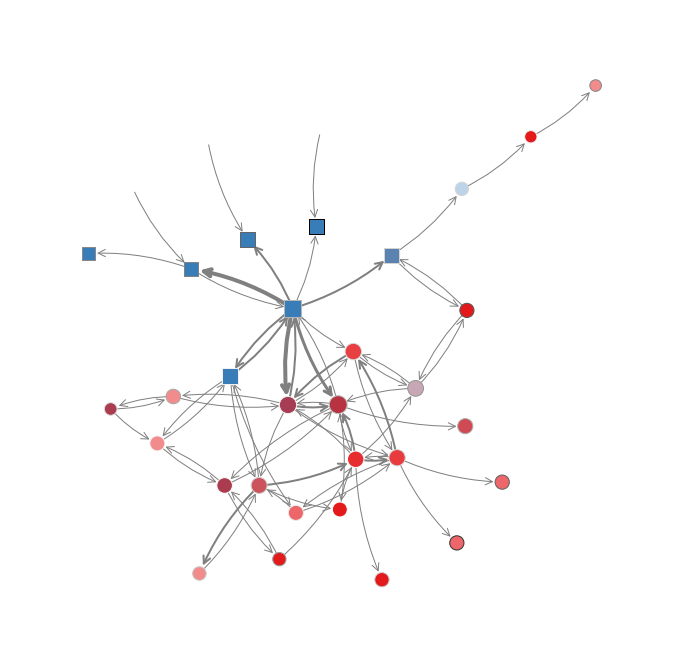

In [37]:
cs.draw_graph(
    G_singleplex, 
    node_size=nx.closeness_centrality(G_singleplex), 
    node_size_factor=1000, 
    curved_edges=True)

In [38]:
#closeness from this node to other nodes
nx.closeness_centrality(G_singleplex.reverse())[3]

0.30559593023255816

### distance

Clotheness centrality was defined as the inverse of farness, which in turn, is the sum of distances to all other nodes [1]. The intent behind this measure was to identify the nodes which could reach others quickly [2]. 

The weights of edges could be considered as costs in the shortest pathes calculation. The least costly path connecting two nodes was the shortest path between them. To create a closeness measure, one should inverte the numbers (1 divided by the weight). Thus, a high weight is transformed into a low closeness, and a low weight is transformed into a high closeness.



1. Freeman, L. C., 1978. Centrality in social networks: Conceptual clarification. Social Networks 1, 215-239.
2. Opsahl, T., Agneessens, F., Skvoretz, J., 2010. Node centrality in weighted networks: Generalizing degree and shortest paths. Social Networks 32 (3), 245-251.


In [39]:
#let's check which edges has weights > 1
relations_singleplex[relations_singleplex.weight>1]

,family_id_from,family_id_to,weight
0,0,1,2
1,0,2,2
2,0,3,4
4,0,8,2
5,0,12,4
7,0,23,3
10,2,0,2
23,12,0,2
28,12,23,2
29,13,12,2


In [40]:
#convert weight to distance
relations.loc[:,"weight_norm_distance"] = 1./relations.weight
relations_singleplex.loc[:,"weight_norm_distance"] = 1./relations.weight
relations_singleplex_undirected.loc[:,"weight_norm_distance"] = 1./relations.weight

#transform into dictionaty where key is tuple and values is the new attribute
attr_dict=relations.set_index(['family_id_from', 'family_id_to',"domain_id"])["weight_norm_distance"].to_dict()
attr_dict_2=relations_singleplex.set_index(['family_id_from', 'family_id_to'])["weight_norm_distance"].to_dict()
attr_dict_3=relations_singleplex_undirected.set_index(['family_id_from', 'family_id_to'])["weight_norm_distance"].to_dict()

#add new attribute
nx.set_edge_attributes(G, values=attr_dict, name='weight_norm_distance')
nx.set_edge_attributes(G_singleplex, values=attr_dict_2, name='weight_norm_distance')
nx.set_edge_attributes(G_singleplex_undirected, values=attr_dict_3, name='weight_norm_distance')

In [41]:
#Closeness to this node from other nodes, where more (stronger) edges would lead to shorter distance
#find the least-costly paths among all nodes

nx.closeness_centrality(G_singleplex, distance="weight_norm_distance")[3]

0.2100840336134454

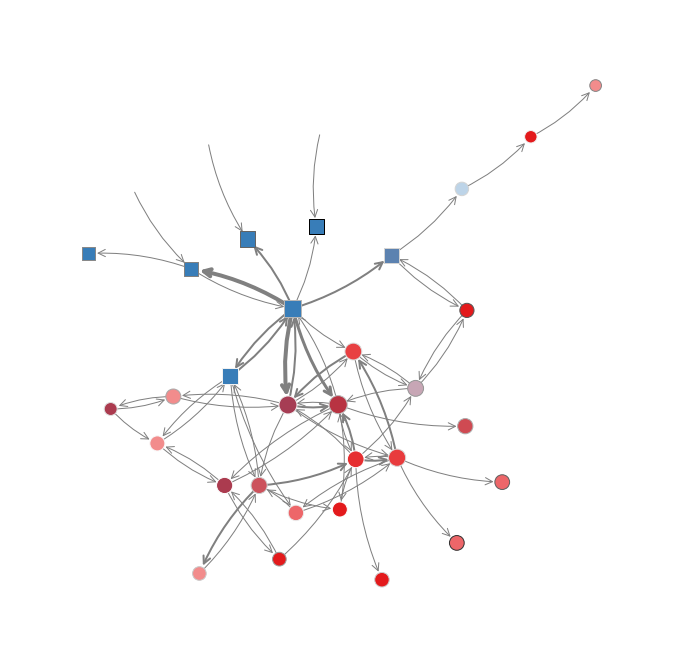

In [42]:
cs.draw_graph(
    G_singleplex, 
    node_size=nx.closeness_centrality(G_singleplex, distance="weight_norm_distance"), 
    node_size_factor=1000, 
    curved_edges=True)

## Betweenness centrality 

It assumes that important nodes connect other nodes. These metrics measure potential control. 

__Betweenness centrality__ of a node _v_ is the sum of the fraction of all-pairs shortest paths that pass through _v_.

`betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None)` where `k` size of random samples to estimate betweenness, `weight` is the name of the attribute that should be used as distance metric and `seed` is random number generation state. 

More detail here https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html

__Betweenness centralities__ cannot be calculated for multigraph in networkx, so we will use it for directed and undirected graph.

Alternatively one can use pymnet (Multilayer Networks Library for Python) library which is beyond the scope of this seminar http://www.mkivela.com/pymnet/ 

In [43]:
#shows who is the mediator in the network
nx.betweenness_centrality(G_singleplex)[12]

0.13161962365591398

In [44]:
#This generalisation takes into account, that in weighted networks, 
#the transaction between two nodes might be quicker along paths with more intermediate nodes 
#that are strongly connected than paths with fewer weakly-connected intermediate nodes. 
#This is due to the fact that the strongly connected intermediate nodes have, 
#for example, more frequent contact than the weakly connected ones. 

#"In a weighted network the links connecting the nodes are no longer treated as binary interactions, 
#but are weighted in proportion to their capacity, influence, frequency, etc., 
#which adds another dimension of heterogeneity within the network beyond the topological effects."


nx.betweenness_centrality(G_singleplex, weight="weight_norm_distance")[12]

0.14243951612903225

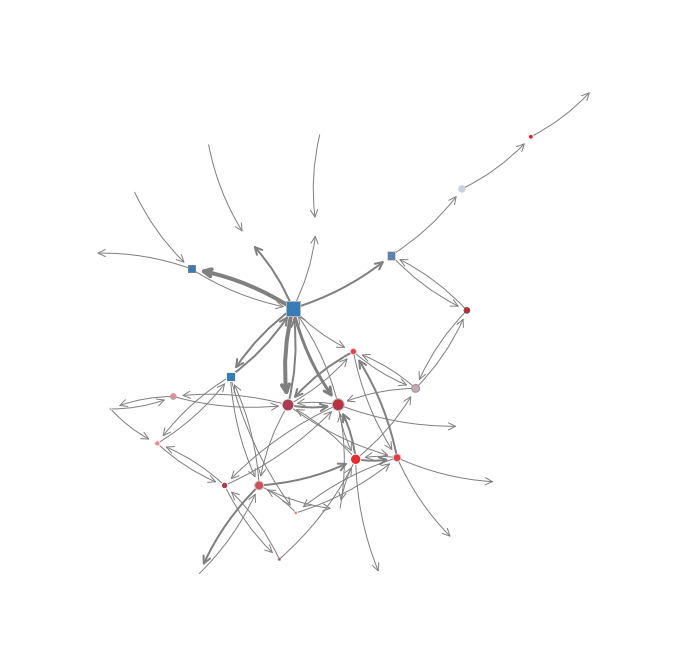

In [45]:
cs.draw_graph(
    G_singleplex, 
    node_size=nx.betweenness_centrality(G_singleplex, weight="weight_norm_distance"), 
    node_size_factor=1000, 
    curved_edges=True)

In [46]:
nx.betweenness_centrality(G_singleplex_undirected, weight="weight_norm_distance")[12]

0.19603494623655915

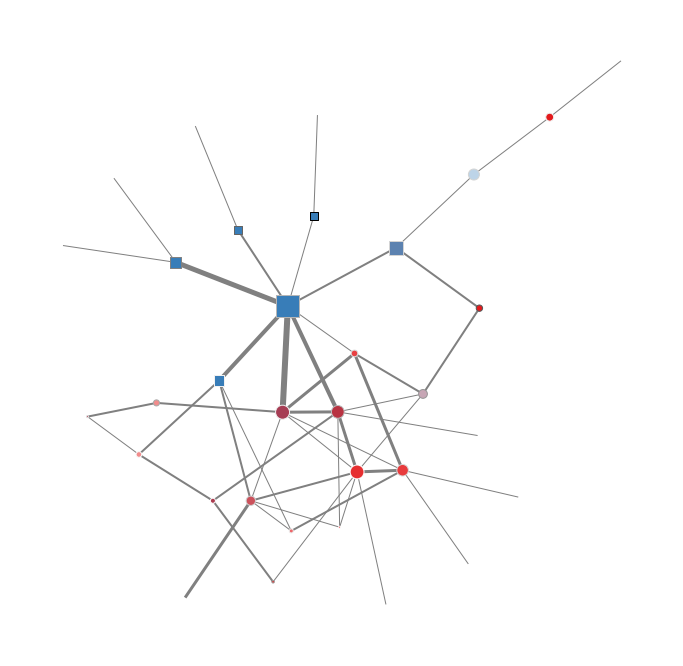

In [47]:
cs.draw_graph(
    G_singleplex_undirected, 
    node_size=nx.betweenness_centrality(G_singleplex_undirected,weight="weight_norm_distance"), 
    node_size_factor=1000)

## Edge betweenness centrality

It assumes that important edges connect with many other nodes from different "clusters".  

Betweenness centrality of an edge `e` is the sum of the fraction of all-pairs shortest paths that pass through `e`.

`edge_betweenness_centrality(G, k=None, normalized=True, weight=None, seed=None)` 

More details find here https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html

In [48]:
nx.edge_betweenness_centrality(G_singleplex)

{(0, 1): 0.07013888888888888,
 (0, 2): 0.019996843434343433,
 (0, 3): 0.03598484848484849,
 (0, 6): 0.019886363636363636,
 (0, 8): 0.019886363636363636,
 (0, 12): 0.020833333333333332,
 (0, 13): 0.01444128787878788,
 (0, 23): 0.019886363636363633,
 (1, 26): 0.0321969696969697,
 (1, 32): 0.05965909090909091,
 (2, 0): 0.058317550505050504,
 (2, 19): 0.014835858585858588,
 (2, 20): 0.015388257575757576,
 (2, 29): 0.01158459595959596,
 (3, 0): 0.053030303030303025,
 (3, 4): 0.019886363636363636,
 (5, 3): 0.028409090909090908,
 (7, 6): 0.000946969696969697,
 (9, 8): 0.000946969696969697,
 (10, 11): 0.014835858585858584,
 (10, 29): 0.015261994949494947,
 (11, 10): 0.02157512626262626,
 (11, 12): 0.03819444444444444,
 (12, 0): 0.042029671717171715,
 (12, 11): 0.03641098484848485,
 (12, 13): 0.00946969696969697,
 (12, 16): 0.020675505050505045,
 (12, 20): 0.031044823232323233,
 (12, 23): 0.011474116161616163,
 (13, 12): 0.027241161616161615,
 (13, 16): 0.021780303030303032,
 (13, 25): 0.015861

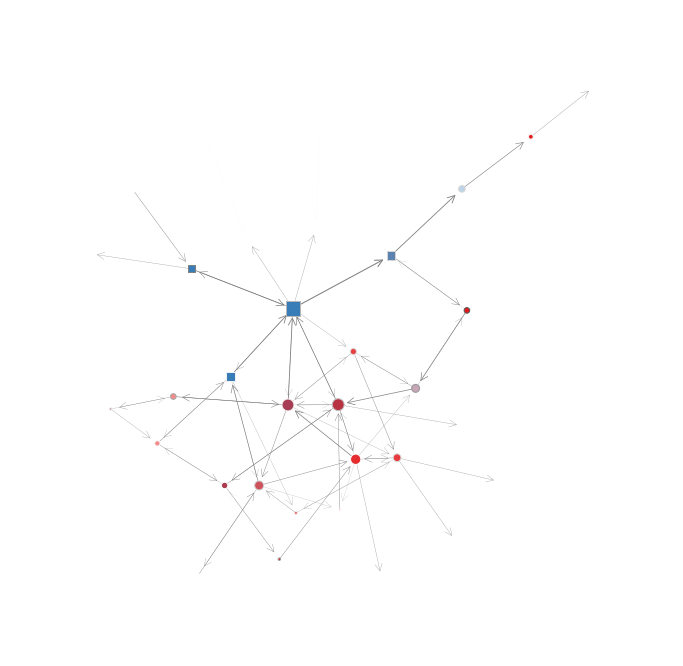

In [49]:
#let's use edge betweenness to plot the width of the edges
cs.draw_graph(
    G_singleplex, 
    node_size=nx.betweenness_centrality(G_singleplex,weight="weight_norm_distance"), 
    node_size_factor=1000, 
    edge_width=list(nx.edge_betweenness_centrality(G_singleplex,weight="weight_norm_distance").values()), 
    edge_width_factor=14)

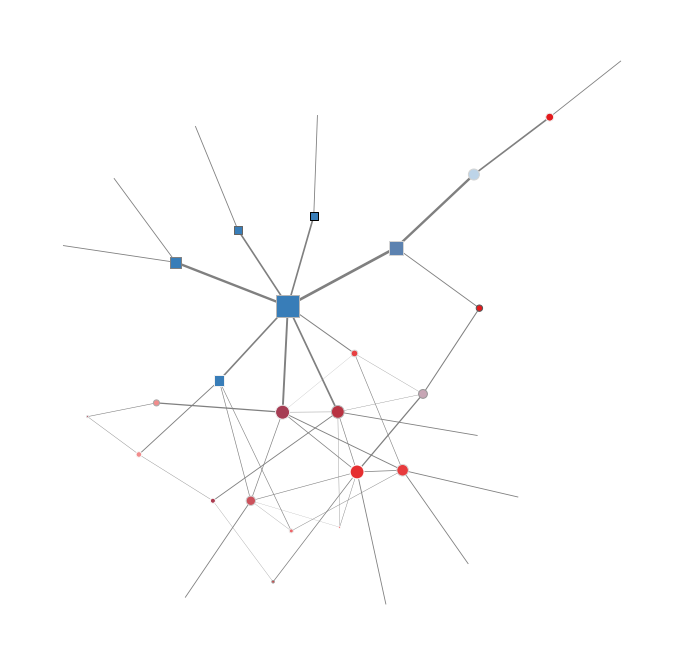

In [50]:
#on undirected network
cs.draw_graph(
    G_singleplex_undirected, 
    node_size=nx.betweenness_centrality(G_singleplex_undirected,weight="weight_norm_distance"), 
    node_size_factor=1000, 
    edge_width=list(nx.edge_betweenness_centrality(G_singleplex_undirected,weight="weight_norm_distance").values()), 
    edge_width_factor=14, 
    edge_color=None
    )

## PageRank 

__PageRank__ counts the number and quality of links to a node to determine a rough estimate of how important the node is. The underlying assumption is that more important nodes are likely to receive more edges from other nodes.

`pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)`
where `alpha` is a damping parameter for PageRank, default=0.85. Damping is (1-p_jump) where p_jump is likelihood of jumping to an arbitrary node.

Note: Undirected graphs will be converted to a directed graph with two directed edges for each undirected edge.

More details here https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

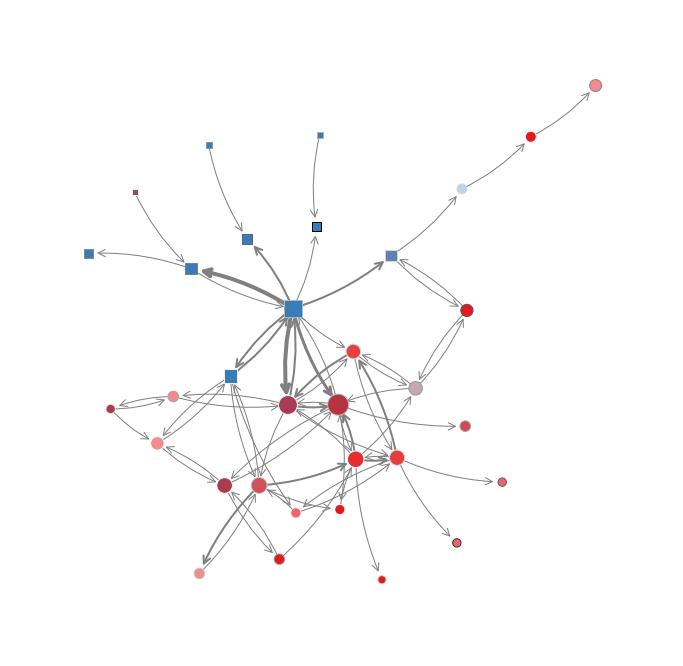

In [51]:
#Important nodes are those with many inlinks from important nodes.
#singleplex network (i.e., non-multiplex directed network)
cs.draw_graph(
    G_singleplex, 
    node_size=nx.pagerank(G_singleplex,alpha=0.9, weight="weight"), 
    node_size_factor=5000, 
    curved_edges=True,
    labels='no text', 
)

In case of Directed weighted graph, the strength of each directed edge is taken into account. 

In case of Undirected weighted graph, the the strength of undirected edge would be assumed as bidirectional. In other words, PageRank is calculated on "artificial" directed graph. Meaning that we will overestimate the strength of some edges. 

In [52]:
#PageRanks of undirected network and of directed network, 
# where each directed edge has the same weight as undirected edge

#We can create directed graph from undirected, though we just replace each edge (u, v, data) 
#with two directed edges (u, v, data) and (v, u, data) 
#G_simple_directed = G_simple.to_directed()

pd.DataFrame({"undirected":nx.pagerank(G_singleplex_undirected,alpha=0.9),
              "directed_bidorectional":nx.pagerank(G_singleplex_undirected.to_directed(),alpha=0.9)} )

,undirected,directed_bidorectional
0,0.125648,0.125648
1,0.031770,0.031770
2,0.044524,0.044524
3,0.040465,0.040465
4,0.008233,0.008233
5,0.008233,0.008233
6,0.017278,0.017278
7,0.010806,0.010806
8,0.020279,0.020279
9,0.009114,0.009114


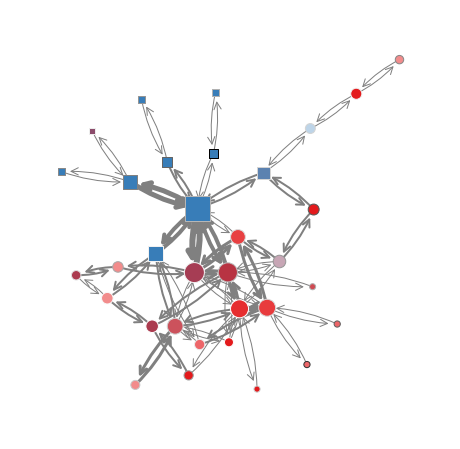

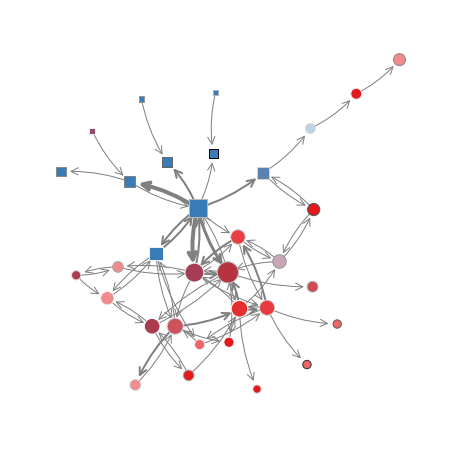

In [53]:
cs.draw_graph(
    G_singleplex_undirected.to_directed(), 
    node_size=nx.pagerank(G_singleplex_undirected.to_directed(),alpha=0.9), 
    node_size_factor=5000, 
    curved_edges=True,
    figsize="medium")
cs.draw_graph(
    G_singleplex, 
    node_size=nx.pagerank(G_singleplex,alpha=0.9, weight="weight"), 
    node_size_factor=5000, 
    curved_edges=True,
    figsize="medium",
)

### Advanced notes on PageRank calculation for Multigraph

To calculate PageRank on multilayered graphs one can use

`nx.pagerank_numpy(G, alpha=0.9)`
 or
`nx.pagerank_scipy(G, alpha=0.9)`

>This implementation works with Multi(Di)Graphs. For multigraphs the weight between two nodes is set to be the sum of all edge weights between those nodes.

More details here:
- https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank_numpy.html
- https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank_scipy.html

## Store data to DataFrame

In [54]:
families.loc[:,'degree_centrality'] = nx.degree_centrality(G).values()

In [55]:
families.head()

,family_id,family,party_id,gross_wealth_mean,date_of_first_prior_mean,block_size,numbers_active_medici,numbers_active_oligarch,numbers_active_neutral,pos_x,pos_y,partisanship_color,status_color,degree_centrality
0,0,MEDICI,0,82702,1318,3,7,0,0,-0.0776,0.0391,#387db8,#b6b6b6,0.65625
1,1,TORNABUONI,0,42840,1303,7,8,1,1,0.0776,0.1251,#5c82b0,#d4d4d4,0.15625
2,2,GUICCIARDINI,0,40617,1289,5,6,0,0,-0.1761,-0.0705,#387db8,#f1f1f1,0.28125
3,3,GINORI,0,21167,1344,2,11,0,0,-0.2381,0.1034,#387db8,#818181,0.15625
4,4,DIETISALVI,0,13137,1340,2,3,0,0,-0.4000,0.1282,#387db8,#898989,0.03125
